# Clustering & PCA Assignment

In [185]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

#Hopkins Statistics
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan

warnings.filterwarnings('ignore')

In [186]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

In [187]:
#Reading the data from csv
CountryDF = pd.read_csv("Country-data.csv")

In [188]:
CountryDF.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [189]:
#Columns exports, imports, & health are given as %age of the Total GDP. So, Lets calculate exact value.
CountryDF['exports'] = (CountryDF['exports'] / 100) * CountryDF['exports']
CountryDF['imports'] = (CountryDF['imports'] / 100) * CountryDF['imports']
CountryDF['health'] = (CountryDF['health'] / 100) * CountryDF['health']

In [190]:
#Shape of the Data, we have around 167 records
CountryDF.shape

(167, 10)

In [191]:
#All Columns and record count and data types.
CountryDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
country       167 non-null object
child_mort    167 non-null float64
exports       167 non-null float64
health        167 non-null float64
imports       167 non-null float64
income        167 non-null int64
inflation     167 non-null float64
life_expec    167 non-null float64
total_fer     167 non-null float64
gdpp          167 non-null int64
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [192]:
CountryDF.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,24.368667,0.539535,27.812869,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,44.596100,0.441050,36.157512,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.000119,0.032761,0.000043,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,5.664400,0.242065,9.120800,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,12.250000,0.399424,18.748900,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,26.368250,0.739625,34.515850,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,400.000000,3.204100,302.760000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [193]:
#Missing Value Check
CountryDF.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

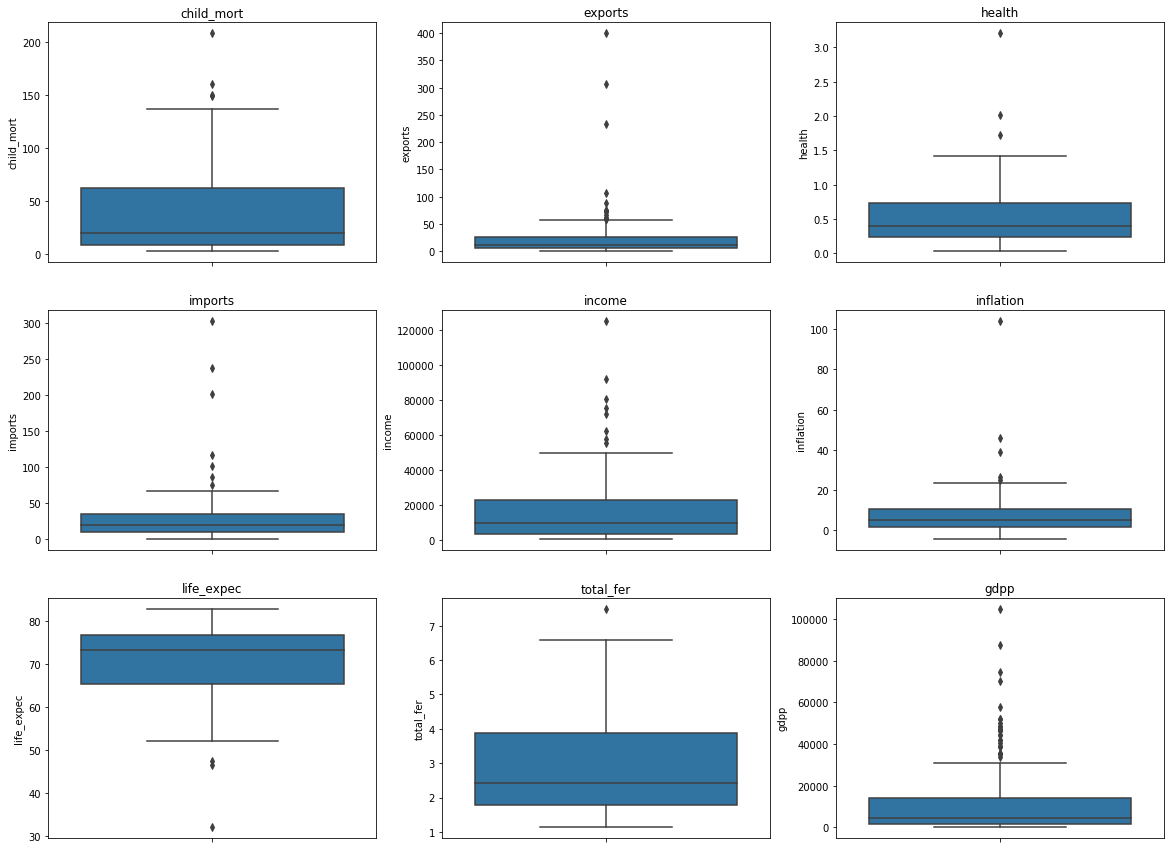

In [194]:
# Examining outliers column wise
plt.figure(figsize=(20,15))
i = 1
for col in CountryDF.describe().columns:
    plt.subplot(3,3,i)
    sns.boxplot(y=col,data = CountryDF)
    i+=1
    plt.title(col)
plt.show()

In [195]:
# We can see outliers in all columns, Treating outliers with capping the values
CountryDF_Test = CountryDF
for col in CountryDF_Test.describe().columns:
    q1 = CountryDF_Test[col].quantile(0.02)
    q2 = CountryDF_Test[col].quantile(0.95)
    CountryDF_Test[col] = np.where(CountryDF_Test[col]< q1, q1, CountryDF_Test[col])
    CountryDF_Test[col] = np.where(CountryDF_Test[col]> q2, q2, CountryDF_Test[col])

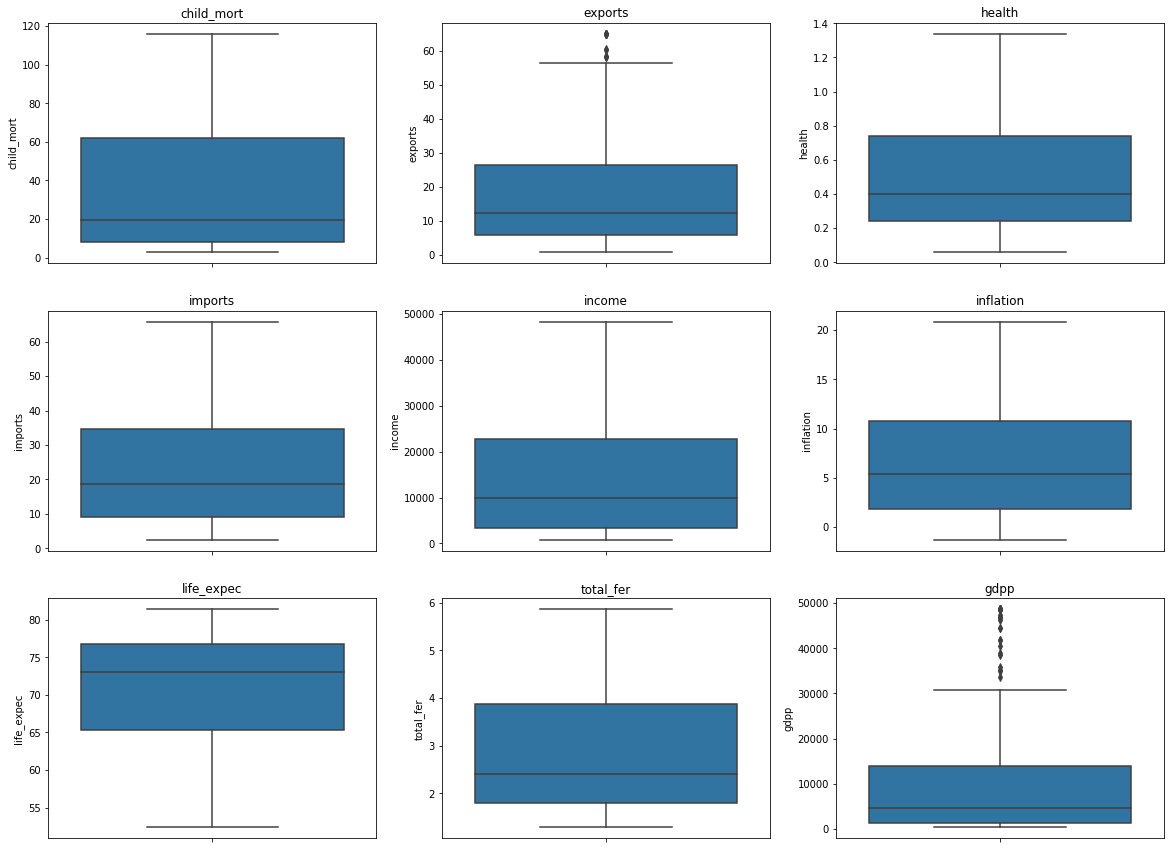

In [196]:
# Examining outliers column wise again
plt.figure(figsize=(20,15))
i = 1
for col in CountryDF_Test.describe().columns:
    plt.subplot(3,3,i)
    sns.boxplot(y=col,data = CountryDF_Test)
    i+=1
    plt.title(col)
plt.show()

In [251]:
#GDPP has still lot of outliers, capping once again
q2 = CountryDF_Test['gdpp'].quantile(.85)
CountryDF_Test['gdpp'] = np.where(CountryDF_Test['gdpp']> q2, q2, CountryDF_Test['gdpp'])

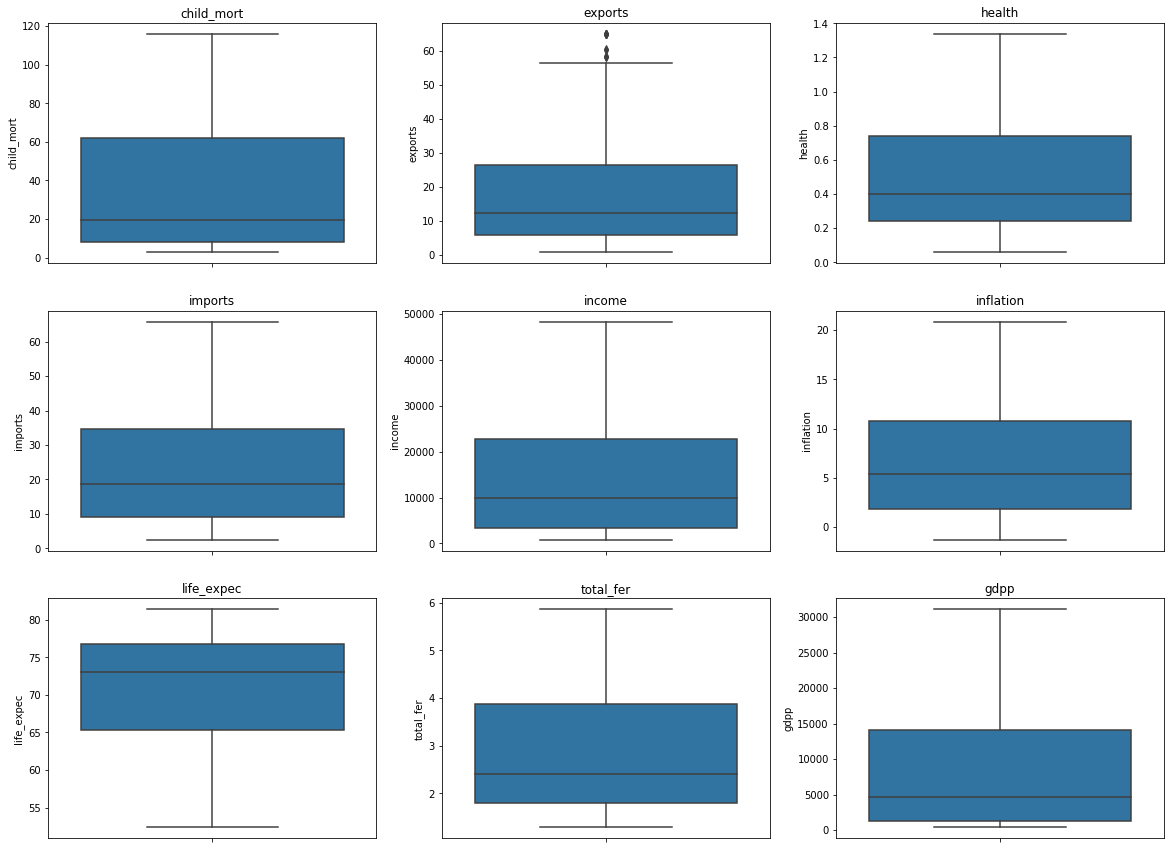

In [198]:
# Examining outliers column wise
plt.figure(figsize=(20,15))
i = 1
for col in CountryDF_Test.describe().columns:
    plt.subplot(3,3,i)
    sns.boxplot(y=col,data = CountryDF_Test)
    i+=1
    plt.title(col)
plt.show()

In [199]:
# Filter columns with numeric data.
scalerDf = CountryDF[CountryDF.describe().columns]

In [200]:
# Correlation Matrix for the numerical columns.
cor = scalerDf.corr()
cor

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
child_mort,1.000000,-0.309506,-0.224256,-0.136227,-0.639369,0.329164,-0.889168,0.892368,-0.611258
exports,-0.309506,1.000000,-0.125077,0.579933,0.466166,-0.071640,0.292141,-0.300014,0.362632
health,-0.224256,-0.125077,1.000000,0.136136,0.286395,-0.334856,0.239606,-0.211825,0.386226
imports,-0.136227,0.579933,0.136136,1.000000,0.003838,-0.273904,0.030995,-0.158357,-0.021144
income,-0.639369,0.466166,0.286395,0.003838,1.000000,-0.240859,0.721684,-0.591592,0.957007
inflation,0.329164,-0.071640,-0.334856,-0.273904,-0.240859,1.000000,-0.331790,0.372208,-0.337004
life_expec,-0.889168,0.292141,0.239606,0.030995,0.721684,-0.331790,1.000000,-0.811851,0.714186
total_fer,0.892368,-0.300014,-0.211825,-0.158357,-0.591592,0.372208,-0.811851,1.000000,-0.560506
gdpp,-0.611258,0.362632,0.386226,-0.021144,0.957007,-0.337004,0.714186,-0.560506,1.000000


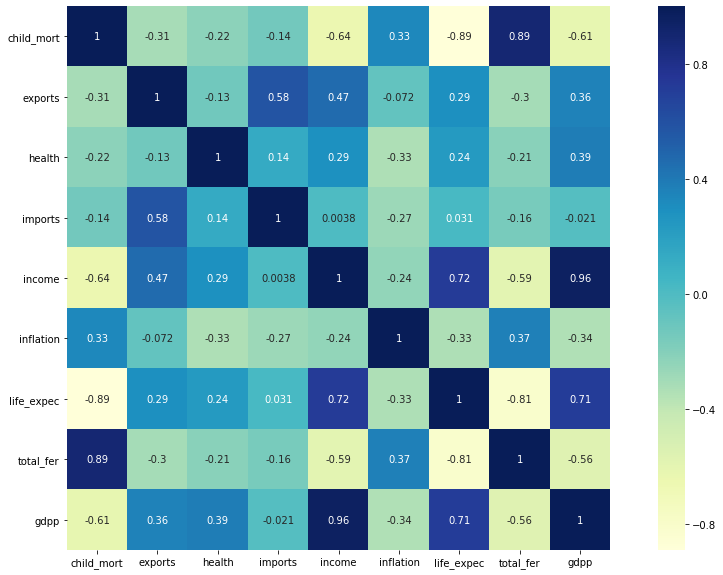

In [201]:
plt.figure(figsize = (17,10))
ax = sns.heatmap(cor,cmap="YlGnBu", annot=True,square=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.yticks(rotation= 0) 
plt.show()

# Correlation Matrix and heat map shows a lot of Colinearity and strong correlation between features which needs to be removed using PCA.

In [202]:
#Most important step is scaling the data
scaler = StandardScaler()
scaled = scaler.fit_transform(scalerDf)

In [203]:
scaled

array([[ 1.47939263, -1.00055078,  0.14455109, ..., -1.75692117,
         2.01772807, -0.8644533 ],
       [-0.55923181, -0.62784376, -0.24760751, ...,  0.67691888,
        -0.88248913, -0.54240684],
       [-0.2628557 , -0.25156225, -0.93507808, ...,  0.70113619,
        -0.02007442, -0.50871807],
       ...,
       [-0.37365051,  1.76968676, -0.14297638, ...,  0.28944185,
        -0.67384041, -0.7955279 ],
       [ 0.54040665, -0.56463614, -0.68062053, ..., -0.38864293,
         1.21790798, -0.7955279 ],
       [ 1.28273185, -0.30908118, -0.46883887, ..., -2.22286228,
         1.72561986, -0.78187028]])

In [204]:
scaledDf = pd.DataFrame(scaled, columns = CountryDF.describe().columns)
scaledDf.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.479393,-1.000551,0.144551,-0.203826,-0.958721,0.392219,-1.756921,2.017728,-0.864453
1,-0.559232,-0.627844,-0.247608,-0.014326,-0.394270,-0.391551,0.676919,-0.882489,-0.542407
2,-0.262856,-0.251562,-0.935078,-0.768053,-0.192777,1.446745,0.701136,-0.020074,-0.508718
3,2.194019,1.059849,-1.184764,-0.300014,-0.667676,2.202014,-1.284684,2.046243,-0.593395
4,-0.733734,0.073025,-0.423873,0.592190,0.227847,-0.874480,0.737462,-0.548651,0.196015


In [205]:
scaledDf.describe().round(2)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.00,167.00,167.00,167.00,167.00,167.00,167.00,167.00,167.00
mean,0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-0.94,-1.01,-1.24,-1.17,-1.01,-1.31,-2.22,-1.14,-0.88
25%,-0.79,-0.75,-0.75,-0.81,-0.84,-0.82,-0.66,-0.78,-0.79
50%,-0.48,-0.39,-0.33,-0.28,-0.39,-0.25,0.29,-0.35,-0.49
75%,0.70,0.38,0.59,0.58,0.48,0.60,0.74,0.67,0.36
max,2.19,2.48,2.20,2.30,2.21,2.20,1.29,2.05,1.92


In [206]:
pca = PCA(svd_solver = 'randomized', random_state=100)
pca.fit(scaledDf)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=100,
    svd_solver='randomized', tol=0.0, whiten=False)

In [207]:
pca.components_

array([[-0.42035777,  0.22240083,  0.17923067,  0.09922644,  0.41070104,
        -0.22341314,  0.42777339, -0.40517576,  0.40757999],
       [ 0.05333803,  0.61658431, -0.19272336,  0.72408165, -0.08985181,
        -0.07000826, -0.1351097 ,  0.02528421, -0.1538632 ],
       [ 0.09321165, -0.28532837,  0.64997705,  0.29154267, -0.18804417,
        -0.5882375 , -0.12229943,  0.04964265, -0.0602205 ],
       [ 0.37256112,  0.25768034,  0.37084164, -0.03529534,  0.42300851,
         0.22707659, -0.21582494,  0.4295701 ,  0.44092962],
       [-0.2226326 , -0.06290262,  0.51752546,  0.23783418, -0.14893473,
         0.72056134,  0.08498387, -0.17936077, -0.20321797],
       [ 0.08978887,  0.37301122,  0.19027494, -0.39167676, -0.01213635,
        -0.06896549, -0.54530038, -0.58550982, -0.13456437],
       [ 0.07554021, -0.52166045, -0.25583606,  0.40715813,  0.27752691,
         0.12876779, -0.44158035, -0.35067046,  0.28172489],
       [-0.77945204,  0.01675853, -0.00349735, -0.05829817,  0

In [208]:
pca.explained_variance_ratio_

array([0.49431351, 0.16297254, 0.13410609, 0.09676458, 0.06518777,
       0.01820578, 0.0166995 , 0.00860182, 0.00314843])

#### explained_variance_ratio Plot

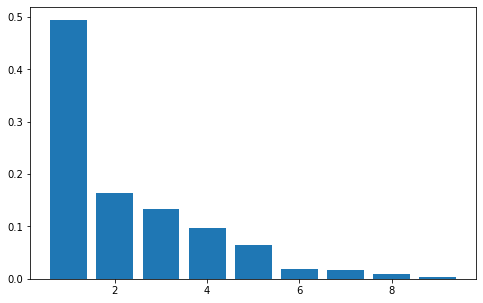

In [209]:
fig = plt.figure(figsize=[8,5])
plt.bar(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)
plt.show()

#### Making the scree plot

In [210]:
#Storing cumulative Sum of the explained_variance_ratio
var_cum = np.cumsum(pca.explained_variance_ratio_)
var_cum

array([0.49431351, 0.65728604, 0.79139213, 0.88815671, 0.95334448,
       0.97155026, 0.98824976, 0.99685157, 1.        ])

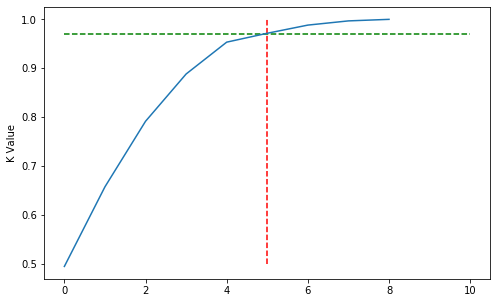

In [211]:
# Scree Plot
fig = plt.figure(figsize=[8,5])
plt.vlines(x=5, ymax=1, ymin=0.5, colors="r", linestyles="--")
plt.hlines(y=0.97, xmax=10, xmin=0, colors="g", linestyles="--")
plt.plot(var_cum)
plt.ylabel("Cumulative variance explained")
plt.ylabel("K Value")
plt.show()

In [212]:
#Applying PCA for 5 components
pca5 = PCA(svd_solver = 'randomized', n_components=5, random_state=100)
newdata = pca5.fit_transform(scaledDf)

In [213]:
newdata.shape

(167, 5)

In [214]:
df = pd.DataFrame(newdata, columns=["PC1", "PC2","PC3", "PC4",'PC5'])

CountryDataDF = pd.concat([CountryDF['country'],df], axis = 1)

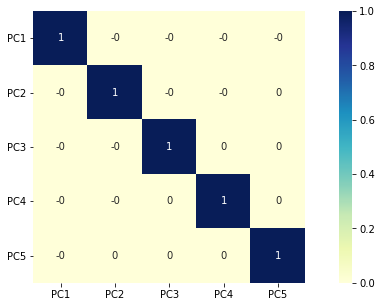

In [215]:
# Correlation Matrix of Principal Components
plt.figure(figsize = (12,5))
ax = sns.heatmap(df.corr().round(2),cmap="YlGnBu", annot=True,square=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.yticks(rotation= 0) 
plt.show()

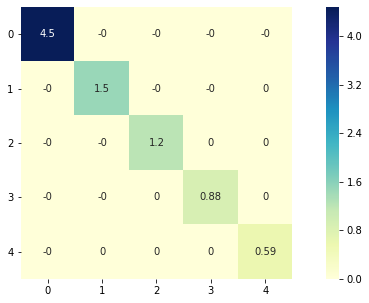

In [216]:
# Covariance Matrix of Principal Components

plt.figure(figsize = (12,5))
ax = sns.heatmap(np.cov(df.T).round(2),cmap="YlGnBu", annot=True,square=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.yticks(rotation= 0) 
plt.show()

### Correlation and Colinearity is removed using PCA.

In [217]:
CountryDataDF.head()

,country,PC1,PC2,PC3,PC4,PC5
0,Afghanistan,-3.241521,-0.233375,0.774571,0.902438,-0.150226
1,Albania,0.401252,-0.347077,0.172432,-1.481490,0.135068
2,Algeria,-0.490938,-0.645979,-1.655312,-0.619689,0.645495
3,Angola,-3.315349,1.004053,-1.830756,1.773957,0.090896
4,Antigua and Barbuda,1.214067,0.413453,0.150237,-0.843246,-0.462568


In [218]:
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [219]:
#Use the Hopkins Statistic function by passing the above dataframe as a paramter
hopkins(df)

0.7070059855578591

## Hopkins Statistics:
The Hopkins statistic, is a statistic which gives a value which indicates the cluster tendency, in other words: how well the data can be clustered.

- If the value is between {0.01, ...,0.3}, the data is regularly spaced.

- If the value is around 0.5, it is random.

- If the value is between {0.7, ..., 0.99}, it has a high tendency to cluster.

In [220]:
kmeans = KMeans(n_clusters= 3, max_iter = 50)
kmeans.fit(df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [221]:
kmeans.labels_

array([0, 1, 1, 0, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 0, 1, 1, 1, 0,
       1, 2, 1, 0, 0, 1, 0, 2, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 2, 2,
       2, 1, 1, 1, 1, 0, 0, 2, 1, 2, 2, 0, 0, 1, 2, 0, 2, 1, 1, 0, 0, 1,
       0, 2, 2, 1, 1, 1, 0, 2, 2, 2, 1, 2, 1, 1, 0, 0, 2, 1, 0, 1, 1, 0,
       0, 1, 1, 2, 1, 0, 0, 1, 1, 0, 2, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       2, 2, 0, 0, 2, 2, 0, 1, 1, 1, 1, 1, 2, 2, 1, 1, 0, 1, 2, 0, 1, 1,
       0, 2, 2, 2, 1, 0, 2, 2, 1, 1, 0, 1, 2, 2, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 2, 2, 2, 1, 1, 1, 1, 1, 0, 0])

## Finding the Optimal Number of Clusters

### SSD

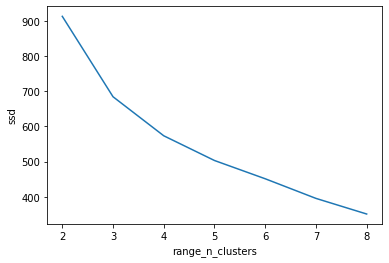

In [222]:
# elbow-curve/Sum of Squared Distance
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(df)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
zipped = zip(range_n_clusters,ssd)
ssdDF = pd.DataFrame(zipped, columns = ['range_n_clusters','ssd'])
# ssd
sns.lineplot(x="range_n_clusters", y="ssd", data=ssdDF)
plt.show()

#### We can clearly see at the k = 3 and then at k = 4, we can see the slope is reduced.

### Silhouette Analysis


In [223]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(df)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(df, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    

For n_clusters=2, the silhouette score is 0.31199006880384617
For n_clusters=3, the silhouette score is 0.3055054119716749
For n_clusters=4, the silhouette score is 0.31662041615837483
For n_clusters=5, the silhouette score is 0.28009427392606817
For n_clusters=6, the silhouette score is 0.28858751502302643
For n_clusters=7, the silhouette score is 0.28943356380538476
For n_clusters=8, the silhouette score is 0.3012711012235851


#### We can see using the Silhouette Score, our score is max when k = 4. Finally we decide on K = 4.

In [224]:
# final model with k=4
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [225]:
kmeans.labels_

array([1, 2, 2, 1, 2, 2, 2, 0, 0, 2, 0, 3, 2, 2, 2, 3, 2, 1, 2, 2, 2, 1,
       2, 3, 2, 1, 1, 2, 1, 0, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 3, 3,
       0, 2, 2, 2, 2, 1, 1, 3, 2, 0, 0, 1, 1, 2, 0, 1, 0, 2, 2, 1, 1, 2,
       1, 3, 0, 2, 2, 2, 1, 3, 0, 0, 2, 0, 2, 2, 1, 1, 3, 2, 1, 2, 2, 1,
       1, 3, 3, 3, 2, 1, 1, 3, 3, 1, 3, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2,
       0, 0, 1, 1, 0, 3, 1, 3, 2, 2, 2, 2, 0, 3, 2, 2, 1, 2, 3, 1, 2, 3,
       1, 3, 3, 3, 2, 1, 0, 0, 2, 2, 1, 2, 0, 0, 2, 1, 3, 1, 1, 2, 2, 2,
       2, 1, 2, 3, 0, 0, 2, 2, 2, 2, 3, 1, 1])

In [226]:
# assign the label
CountryDataDF['cluster_id_KMeans'] = kmeans.labels_
CountryDataDF.head()

,country,PC1,PC2,PC3,PC4,PC5,cluster_id_KMeans
0,Afghanistan,-3.241521,-0.233375,0.774571,0.902438,-0.150226,1
1,Albania,0.401252,-0.347077,0.172432,-1.481490,0.135068,2
2,Algeria,-0.490938,-0.645979,-1.655312,-0.619689,0.645495,2
3,Angola,-3.315349,1.004053,-1.830756,1.773957,0.090896,1
4,Antigua and Barbuda,1.214067,0.413453,0.150237,-0.843246,-0.462568,2


In [227]:
# assign the label
CountryDF['cluster_id_Kmeans'] = kmeans.labels_
CountryDF.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id_Kmeans
0,Afghanistan,90.2,1.0000,0.574564,20.1601,1610.0,9.44,56.2,5.820,553.0,1
1,Albania,16.6,7.8400,0.429025,23.6196,9930.0,4.49,76.3,1.650,4090.0,2
2,Algeria,27.3,14.7456,0.173889,9.8596,12900.0,16.10,76.5,2.890,4460.0,2
3,Angola,116.0,38.8129,0.081225,18.4041,5900.0,20.87,60.1,5.861,3530.0,1
4,Antigua and Barbuda,10.3,20.7025,0.363609,34.6921,19100.0,1.44,76.8,2.130,12200.0,2


In [228]:
# Country List for different Cluster
print(list(CountryDF[(CountryDF.cluster_id_Kmeans == 0)].country), CountryDF['cluster_id_Kmeans'].value_counts()[0])
print()
print(list(CountryDF[(CountryDF.cluster_id_Kmeans == 1)].country), CountryDF['cluster_id_Kmeans'].value_counts()[1])
print()
print(list(CountryDF[(CountryDF.cluster_id_Kmeans == 2)].country), CountryDF['cluster_id_Kmeans'].value_counts()[2])
print()
print(list(CountryDF[(CountryDF.cluster_id_Kmeans == 3)].country), CountryDF['cluster_id_Kmeans'].value_counts()[3])

['Australia', 'Austria', 'Bahamas', 'Canada', 'Denmark', 'Finland', 'France', 'Germany', 'Greece', 'Iceland', 'Israel', 'Italy', 'Japan', 'Netherlands', 'New Zealand', 'Norway', 'Portugal', 'South Korea', 'Spain', 'Sweden', 'Switzerland', 'United Kingdom', 'United States'] 23

['Afghanistan', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 'Cameroon', 'Central African Republic', 'Chad', 'Comoros', 'Congo, Dem. Rep.', 'Congo, Rep.', "Cote d'Ivoire", 'Equatorial Guinea', 'Eritrea', 'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Haiti', 'Iraq', 'Kenya', 'Kiribati', 'Lao', 'Lesotho', 'Liberia', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Pakistan', 'Rwanda', 'Senegal', 'Sierra Leone', 'South Africa', 'Sudan', 'Tanzania', 'Timor-Leste', 'Togo', 'Uganda', 'Yemen', 'Zambia'] 47

['Albania', 'Algeria', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Azerbaijan', 'Bangladesh', 'Barbados', 'Belarus', 'Belize', 'Bhutan', 'Bolivia'

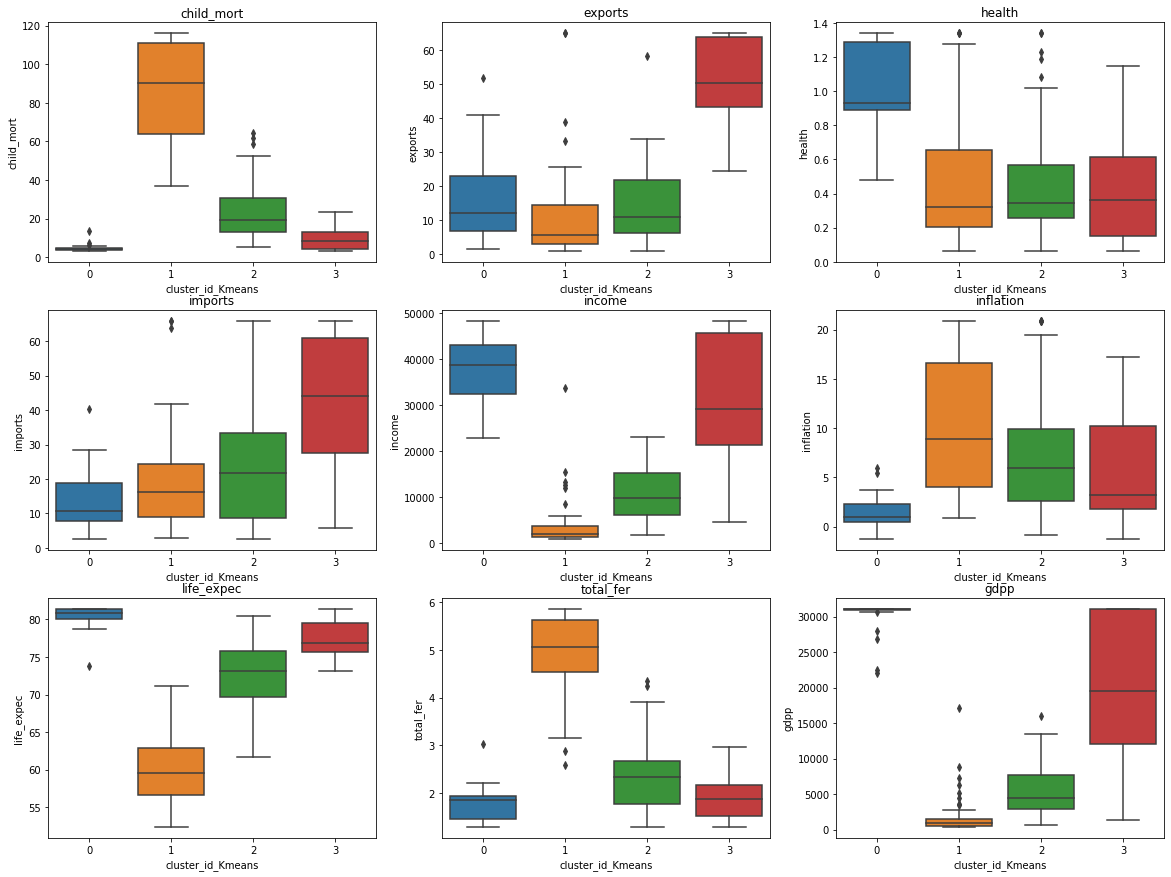

In [229]:
# Examining clusters column wise
columns = ['child_mort','exports','health','imports','income','inflation','life_expec','total_fer','gdpp']
plt.figure(figsize=(20,15))
i = 1
for col in columns:
    plt.subplot(3,3,i)
    sns.boxplot(x='cluster_id_Kmeans', y=col, data = CountryDF)
    i+=1
    plt.title(col)
plt.show()

## Above KMeans Clustering - Inferences
Shows Cluster 1 needs more attention

- child_mortality (Death of children under 5 years of age per 1000 live births) is the highest for Cluster 1 out of the 4.

- exports is the lowest for Cluster 3 which contributes to the GDPP. Hence GDP per capita is also lowest for Cluster 1.

- Income of the majority of the people is very less for Cluster 1 and Inflation is more.

- life_expec or the average number of years a new born child would live is very low for Cluster 1.

#### 47 Countries here are :

['Afghanistan', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 'Cameroon', 'Central African Republic', 'Chad', 'Comoros', 'Congo, Dem. Rep.', 'Congo, Rep.', "Cote d'Ivoire", 'Equatorial Guinea', 'Eritrea', 'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Haiti', 'Iraq', 'Kenya', 'Kiribati', 'Lao', 'Lesotho', 'Liberia', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Pakistan', 'Rwanda', 'Senegal', 'Sierra Leone', 'Solomon Islands', 'South Africa', 'Sudan', 'Tanzania', 'Timor-Leste', 'Togo', 'Uganda', 'Yemen', 'Zambia']

## Hierarchical Clustering

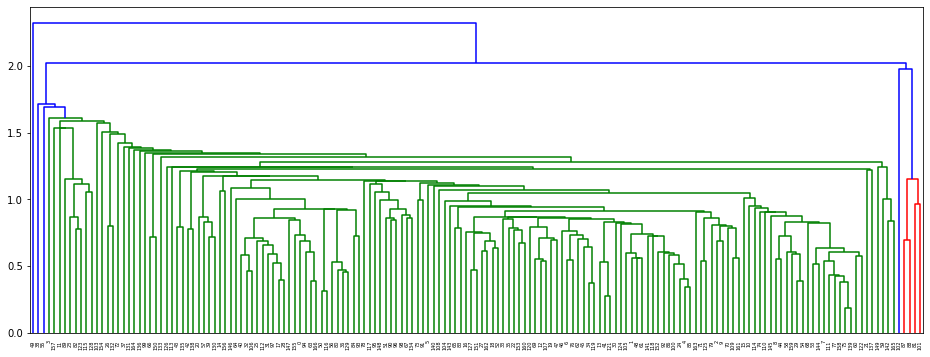

In [230]:
# single linkage, Plotting dendrogram
plt.figure(figsize=(16,6))
mergings = linkage(df, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

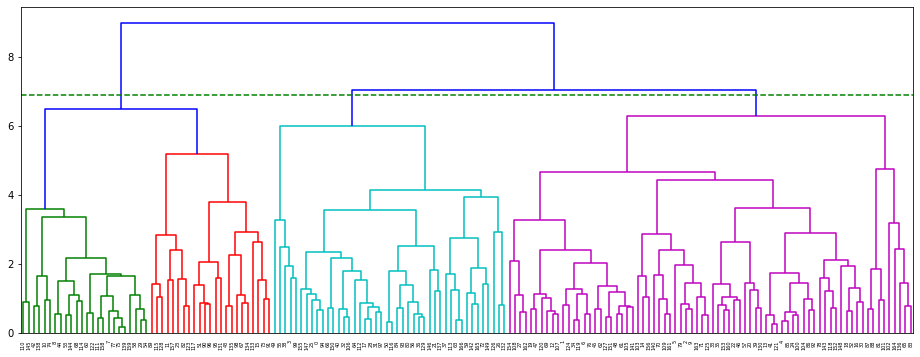

In [231]:
# complete linkage, Plotting dendrogram
plt.figure(figsize=(16,6))
mergings = linkage(df, method="complete", metric='euclidean')
dendrogram(mergings)
plt.hlines(y=6.9, xmax=5000, xmin=0, colors="g", linestyles="--")
plt.show()

# Considering both dendrogram we are choosing Complete Linkage Dendrogram for further analysis

In [232]:
# 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 1, 1, 0, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 0, 1, 1, 1, 0,
       1, 2, 1, 0, 0, 1, 0, 2, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 2, 2,
       2, 1, 1, 1, 1, 0, 0, 2, 1, 2, 2, 0, 0, 1, 2, 0, 2, 1, 1, 0, 0, 1,
       0, 2, 2, 1, 1, 1, 0, 2, 2, 2, 1, 2, 1, 1, 0, 1, 2, 1, 0, 1, 1, 1,
       1, 2, 2, 2, 1, 0, 0, 2, 2, 0, 2, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       2, 2, 0, 0, 2, 2, 0, 2, 1, 1, 1, 1, 2, 2, 1, 1, 0, 1, 2, 0, 1, 2,
       0, 2, 2, 2, 1, 0, 2, 2, 1, 1, 0, 1, 2, 2, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 2, 2, 2, 1, 1, 1, 1, 1, 0, 0])

In [233]:
# assign the label
CountryDataDF['cluster_id_Hier'] = cluster_labels
CountryDataDF.head()

,country,PC1,PC2,PC3,PC4,PC5,cluster_id_KMeans,cluster_id_Hier
0,Afghanistan,-3.241521,-0.233375,0.774571,0.902438,-0.150226,1,0
1,Albania,0.401252,-0.347077,0.172432,-1.481490,0.135068,2,1
2,Algeria,-0.490938,-0.645979,-1.655312,-0.619689,0.645495,2,1
3,Angola,-3.315349,1.004053,-1.830756,1.773957,0.090896,1,0
4,Antigua and Barbuda,1.214067,0.413453,0.150237,-0.843246,-0.462568,2,1


In [234]:
# assign cluster labels
CountryDF['cluster_labels'] = cluster_labels
CountryDF.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id_Kmeans,cluster_labels
0,Afghanistan,90.2,1.0000,0.574564,20.1601,1610.0,9.44,56.2,5.820,553.0,1,0
1,Albania,16.6,7.8400,0.429025,23.6196,9930.0,4.49,76.3,1.650,4090.0,2,1
2,Algeria,27.3,14.7456,0.173889,9.8596,12900.0,16.10,76.5,2.890,4460.0,2,1
3,Angola,116.0,38.8129,0.081225,18.4041,5900.0,20.87,60.1,5.861,3530.0,1,0
4,Antigua and Barbuda,10.3,20.7025,0.363609,34.6921,19100.0,1.44,76.8,2.130,12200.0,2,1


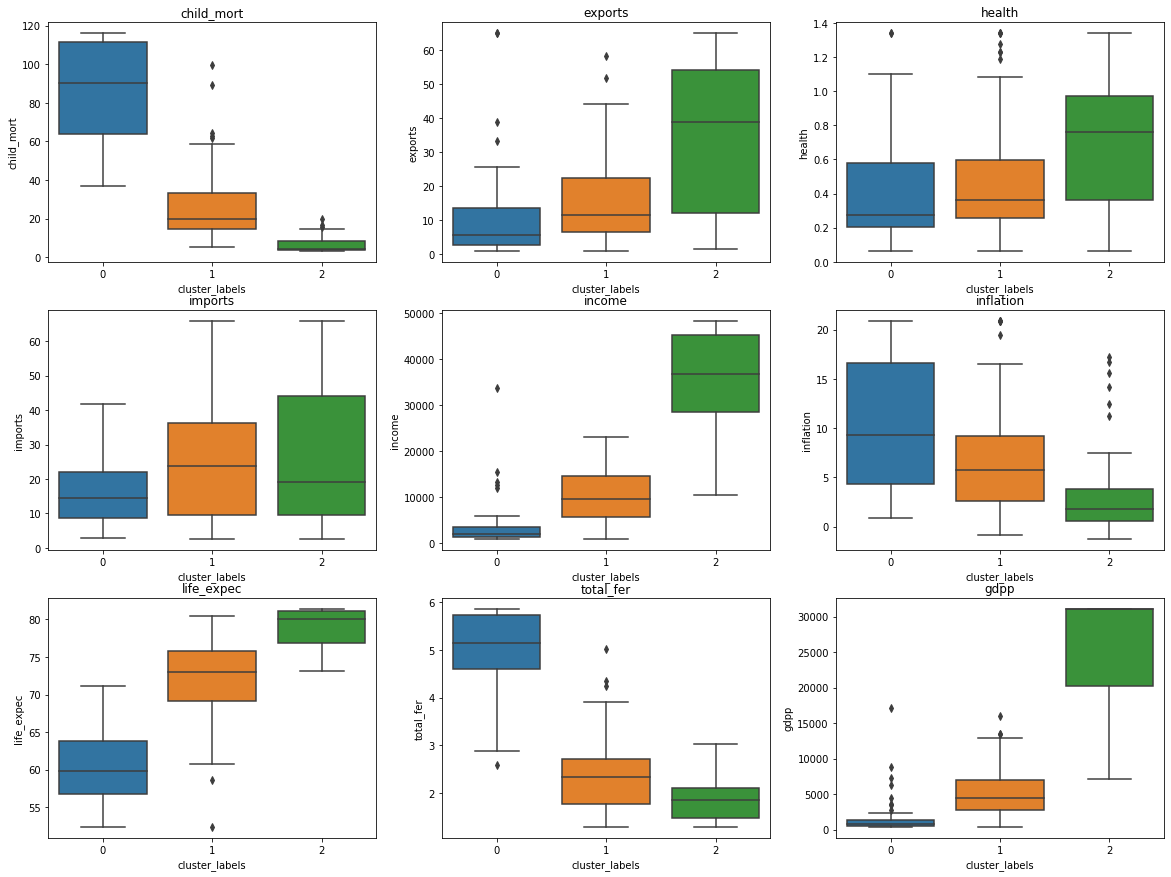

In [235]:
# Examining clusters column wise
columns = ['child_mort','exports','health','imports','income','inflation','life_expec','total_fer','gdpp']
plt.figure(figsize=(20,15))
i = 1
for col in columns:
    plt.subplot(3,3,i)
    sns.boxplot(x='cluster_labels', y=col, data = CountryDF)
    i+=1
    plt.title(col)
plt.show()

## Above Hierarchical Clustering - Inferences
Shows Cluster 0 needs more attention which is similar to Cluster 1 of KMeans

- child_mortality (Death of children under 5 years of age per 1000 live births) is the highest for Cluster 0.

- exports & imports	is the lowest for Cluster 0 which contributes to the GDPP. Hence GDP per capita is also lowest for Category 0.

- Income of the people is very less for Cluster 0 and Inflation is more.

- life_expec or the average number of years a new born child would live is also very low for Cluster 0.
- expenses on health care is also less for Cluster 0 countries.

#### 44 Countries here are :

['Afghanistan', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 'Cameroon', 'Central African Republic', 'Chad', 'Comoros', 'Congo, Dem. Rep.', 'Congo, Rep.', "Cote d'Ivoire", 'Equatorial Guinea', 'Eritrea', 'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Haiti', 'Iraq', 'Kenya', 'Lao', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mozambique', 'Niger', 'Nigeria', 'Pakistan', 'Rwanda', 'Senegal', 'Sierra Leone', 'South Africa', 'Sudan', 'Tajikistan', 'Tanzania', 'Timor-Leste', 'Togo', 'Uganda', 'Yemen', 'Zambia']


In [236]:
# Country List for different Cluster
print(list(CountryDF[(CountryDF.cluster_labels == 0)].country), "Total Countries :", CountryDF['cluster_labels'].value_counts()[0])
print()
print(list(CountryDF[(CountryDF.cluster_labels == 1)].country), "Total Countries :", CountryDF['cluster_labels'].value_counts()[1])
print()
print(list(CountryDF[(CountryDF.cluster_labels == 2)].country), "Total Countries :", CountryDF['cluster_labels'].value_counts()[2])

['Afghanistan', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 'Cameroon', 'Central African Republic', 'Chad', 'Comoros', 'Congo, Dem. Rep.', 'Congo, Rep.', "Cote d'Ivoire", 'Equatorial Guinea', 'Eritrea', 'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Haiti', 'Iraq', 'Kenya', 'Lao', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mozambique', 'Niger', 'Nigeria', 'Pakistan', 'Rwanda', 'Senegal', 'Sierra Leone', 'South Africa', 'Sudan', 'Tajikistan', 'Tanzania', 'Timor-Leste', 'Togo', 'Uganda', 'Yemen', 'Zambia'] Total Countries : 44

['Albania', 'Algeria', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Azerbaijan', 'Bangladesh', 'Barbados', 'Belarus', 'Belize', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Cambodia', 'Cape Verde', 'Chile', 'China', 'Colombia', 'Costa Rica', 'Croatia', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Fiji', 'Georgia', 'Grenada', 'Guatemala', 'Guyana', 'India', 'Indonesia', 'Iran', 'Jamaica', 'Jordan',

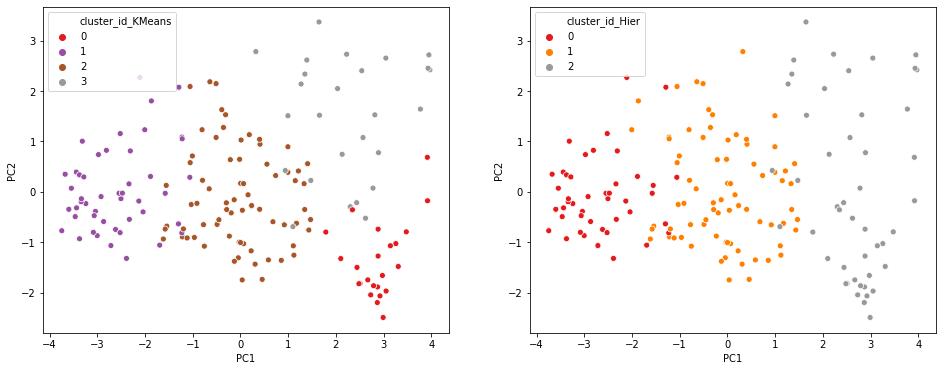

In [237]:
# Comparing KMeans Clusters and Hierarchical clusters for PC1 vs PC2
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
ax = sns.scatterplot(x='PC1',y='PC2',hue='cluster_id_KMeans', palette="Set1", data=CountryDataDF)

plt.subplot(1,2,2)
ax = sns.scatterplot(x='PC1',y='PC2',hue='cluster_id_Hier', palette="Set1", data=CountryDataDF)

In [238]:
CountryDF

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id_Kmeans,cluster_labels
0,Afghanistan,90.2,1.0000,0.574564,20.1601,1610.0,9.44,56.200,5.820,553.0,1,0
1,Albania,16.6,7.8400,0.429025,23.6196,9930.0,4.49,76.300,1.650,4090.0,2,1
2,Algeria,27.3,14.7456,0.173889,9.8596,12900.0,16.10,76.500,2.890,4460.0,2,1
3,Angola,116.0,38.8129,0.081225,18.4041,5900.0,20.87,60.100,5.861,3530.0,1,0
4,Antigua and Barbuda,10.3,20.7025,0.363609,34.6921,19100.0,1.44,76.800,2.130,12200.0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,21.7156,0.275625,27.7729,2950.0,2.62,63.000,3.500,2970.0,2,1
163,Venezuela,17.1,8.1225,0.241081,3.0976,16500.0,20.87,75.400,2.470,13500.0,2,1
164,Vietnam,23.3,51.8400,0.467856,64.3204,4490.0,12.10,73.100,1.950,1310.0,3,1
165,Yemen,56.3,9.0000,0.268324,11.8336,4480.0,20.87,67.500,4.670,1310.0,1,0


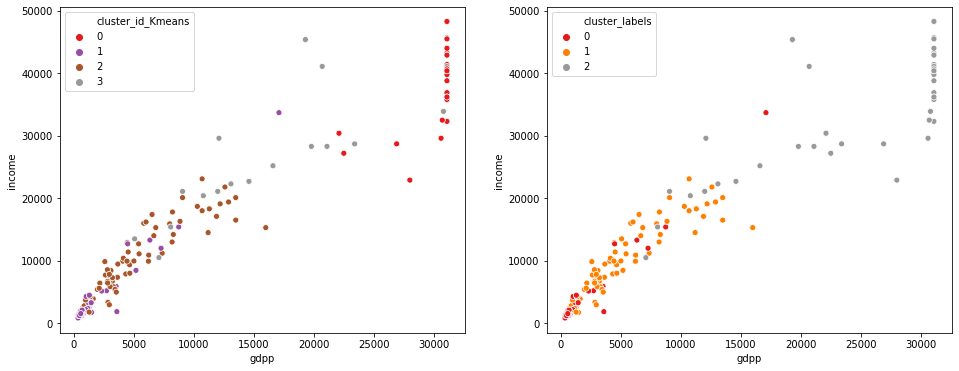

In [239]:
#Here we have compared K-Means cluster vs Hierarchical Cluster based on GDP per Capita vs net person income.
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
ax = sns.scatterplot(x='gdpp',y='income',hue='cluster_id_Kmeans', palette="Set1", data=CountryDF)

plt.subplot(1,2,2)
ax = sns.scatterplot(x='gdpp',y='income',hue='cluster_labels', palette="Set1", data=CountryDF)

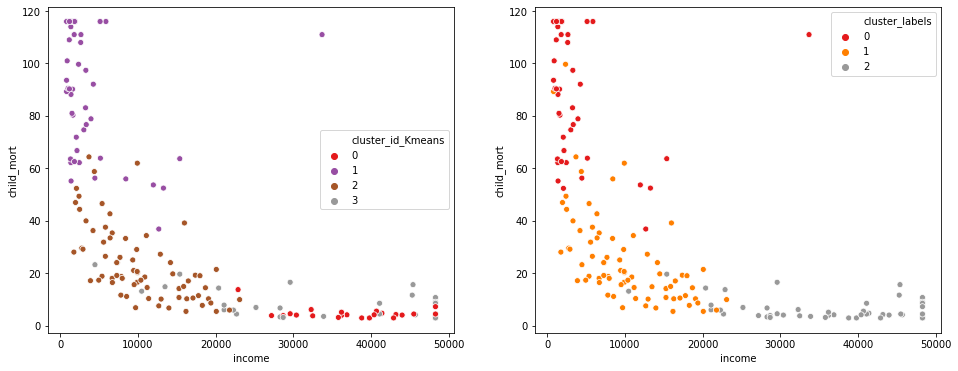

In [240]:
#Here we have compared K-Means cluster vs Hierarchical Cluster based on net person income vs child mortality rate.
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
ax = sns.scatterplot(x='income',y='child_mort',hue='cluster_id_Kmeans', palette="Set1", data=CountryDF)

plt.subplot(1,2,2)
ax = sns.scatterplot(x='income',y='child_mort',hue='cluster_labels', palette="Set1", data=CountryDF)

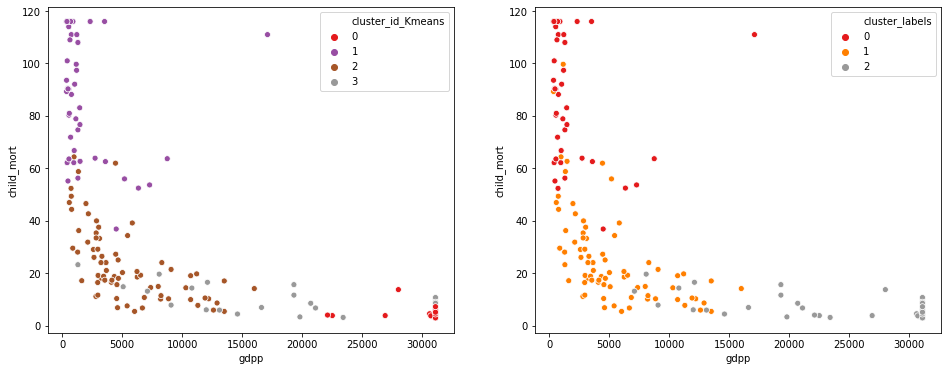

In [241]:
#Here we have compared K-Means cluster vs Hierarchical Cluster based on GDP per Capita vs child mortality.
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
ax = sns.scatterplot(x='gdpp',y='child_mort',hue='cluster_id_Kmeans', palette="Set1", data=CountryDF)

plt.subplot(1,2,2)
ax = sns.scatterplot(x='gdpp',y='child_mort',hue='cluster_labels', palette="Set1", data=CountryDF)

### Insights from above scatter plots
- Due to capping of outliers we can several point in top right corner, hierarchical clustering has perfectly clustered them into 1 cluster in GDP per Capita vs net person income scatter.
- Both GDP per Capita vs child mortality and GDP per Capita vs child mortalityshow a similar trend that where net person income or gdp is less , child mortality rate is higher and where net person income or gdp is higher child mortality rate is less.  

In [242]:
analysis = CountryDF.groupby('cluster_labels').mean()
analysis = analysis.reset_index()
analysis[['cluster_labels','child_mort','income','gdpp']]

,cluster_labels,child_mort,income,gdpp
0,0,87.861364,3964.978182,1888.476364
1,1,25.889474,10108.785263,5248.530526
2,2,6.604255,35874.680851,25444.680851


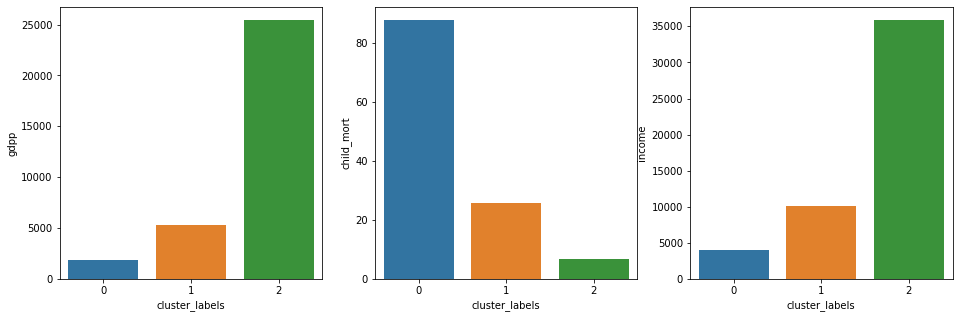

In [249]:
#Barplot on the basis average of 'gdpp','income','child_mort' for each Hierarchical cluster  
plt.figure(figsize=(16,5))
plt.subplot(1,3,1)
sns.barplot(x='cluster_labels',y='gdpp',data = analysis)
plt.subplot(1,3,2)
sns.barplot(x='cluster_labels',y='child_mort',data = analysis)
plt.subplot(1,3,3)
sns.barplot(x='cluster_labels',y='income',data = analysis)
plt.show()

In [250]:
analysis_KMeans = CountryDF.groupby('cluster_id_Kmeans').mean()
analysis_KMeans = analysis_KMeans.reset_index()
analysis_KMeans[['cluster_id_Kmeans','child_mort','income','gdpp']]

,cluster_id_Kmeans,child_mort,income,gdpp
0,0,4.713043,37837.826087,29970.869565
1,1,87.685106,3952.270638,1927.005957
2,2,23.578873,10408.169014,5422.845070
3,3,9.238462,32070.384615,19729.230769


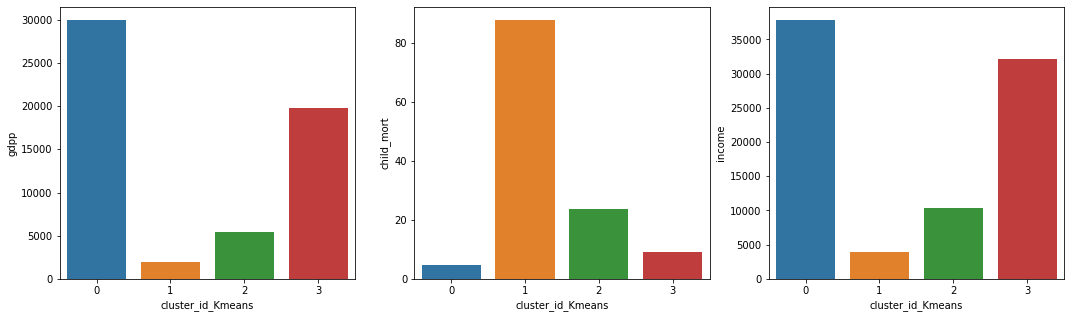

In [248]:
#Barplot on the basis average of 'gdpp','income','child_mort' for each K-Means cluster  
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
sns.barplot(x='cluster_id_Kmeans',y='gdpp',data = analysis_KMeans)
plt.subplot(1,3,2)
sns.barplot(x='cluster_id_Kmeans',y='child_mort',data = analysis_KMeans)
plt.subplot(1,3,3)
sns.barplot(x='cluster_id_Kmeans',y='income',data = analysis_KMeans)
plt.show()

In [246]:
#Sort on the basis of 'gdpp','income','child_mort' to find the top list from hierarchical cluster
CountryDF[(CountryDF.cluster_labels == 0)].sort_values(['gdpp','income','child_mort'], ascending=[True,True,False]).head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id_Kmeans,cluster_labels
37,"Congo, Dem. Rep.",116.0,16.892100,0.625681,24.6016,837.68,20.80,57.5,5.861,364.32,1,0
112,Niger,116.0,4.928400,0.266256,24.1081,837.68,2.55,58.8,5.861,364.32,1,0
26,Burundi,93.6,0.834736,1.338670,15.3664,837.68,12.30,57.7,5.861,364.32,1,0
132,Sierra Leone,116.0,2.822400,1.338670,11.9025,1220.00,17.20,55.0,5.200,399.00,1,0
93,Madagascar,62.2,6.250000,0.142129,18.4900,1390.00,8.79,60.8,4.600,413.00,1,0


In [247]:
#Sort on the basis of 'gdpp','income','child_mort' to find the top list from K-Means cluster
CountryDF[(CountryDF.cluster_id_Kmeans == 1)].sort_values(['gdpp','income','child_mort'], ascending=[True,True,False]).head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id_Kmeans,cluster_labels
37,"Congo, Dem. Rep.",116.0,16.892100,0.625681,24.60160,837.68,20.80,57.5,5.861,364.32,1,0
112,Niger,116.0,4.928400,0.266256,24.10810,837.68,2.55,58.8,5.861,364.32,1,0
26,Burundi,93.6,0.834736,1.338670,15.36640,837.68,12.30,57.7,5.861,364.32,1,0
88,Liberia,89.3,3.648100,1.338670,65.83708,837.68,5.47,60.8,5.020,364.32,1,1
132,Sierra Leone,116.0,2.822400,1.338670,11.90250,1220.00,17.20,55.0,5.200,399.00,1,0


### Final Recommendation for HELP International based on socio-economic and health factors that determine the overall development of the country from both the clustering algorithm are
- Congo, Dem. Rep.
- Niger
- Burundi
- Sierra Leone
- Madagascar
- Liberia